# Attempt to replicate the experiment in CONTRIBUTING TO NEW MUSICOLOGICAL THEORIES WITH COMPUTATIONAL METHODS: THE CASE OF CENTONIZATION IN ARAB-ANDALUSIAN MUSIC

this notebook tried to replicate the centos identified in study.

## Initialization (MANDATORY)
In this cell, all the libraries are loaded. 
Furthermore, a function checks if the metadata related to Arab-Andalusian corpus of Dunya has been downloaded: if not, all metadata will be downloaded. 
At the end, the code creates an object to manage the Dunya metadata.

#### NB: Before to run, remember to add the Dunya token in the costants.py file. This file is in the directory "utilities".

In [1]:
from utilities.recordingcomputation import *
from utilities.dunyautilities import *
from utilities.metadataStatistics import *
from utilities.constants import *
from gui.gui_corpora import *

# download metadata from Dunya
if not check_dunya_metadata():
    print("Downloading metadata from Dunya...")
    collect_metadata()

# create an object with all the well-structured metadata
print("Analyzing Dunya Metadata...")
cm = CollectionMetadata()
print("Collection of metadata created")

Analyzing Dunya Metadata...


/notebooks/utilities/metadataStatistics.py:46: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat([df, new_row])


Collection of metadata created


## Select a list of recordings

The widget of this cell allows to select a subset of the Arab-Andalusian corpus. With the characteristics of the first row, it is possible to select a list of recordings with a specific nawba, tab, mizan and form. All these data come from Dunya metadata. 

Options in the second row allow to select the recordings depending if the mp3 file and/or xml score and/or Musicbrainz metadata are downloaded or not.
It is also possible to select only the recordings that have been analysed or not. 

Furthermore, the list of resulting recordings could be manually tweaked using checkboxes.

In [2]:
selector = SelectionGui(cm, 10)

To extract the list of recordings from the previous interface, it is necessary to run the next cell. 
The resulting list contains all the Musicbrainz IDs of the selected recordings.

In [38]:
rmbid_list1 = selector.get_rmbid_list()
print("Number of tracks: " + str(len(rmbid_list1)))

Number of tracks: 23


## Download mp3, score, Musicbrainz metadata, lyrics and pitch track

With this function, it is possible to check the correctness of the list of Musicbrainz IDs. Incorrect IDs are showed.

In [39]:
check_before_download(rmbid_list1, cm)

List of recordings in Dunya: 
['b3d92934-0946-4f2d-8183-312450d7e45e', '9727ddbe-eb79-461b-9861-8a60336b17f6', '33423585-e406-40ec-ba28-88b0768cb668', 'e3003cd0-430a-4481-a33d-c15c22da2404', 'e22549ae-4a0c-43ef-87f4-e0f81ed49d58', 'a1eac726-208e-4c24-bd57-e34e9e93dcd3', '4342021d-03a1-4727-8c0f-3c23180ef374', '97223154-d5c2-4c37-8e6c-4c998056a674', 'd4cadf34-1074-44ce-9928-f438198d5d6d', '2d2683c4-4b3e-4430-a254-c828427bdcc7', 'c20e4852-d140-4909-acab-e850c0e7d8e8', '1630e9c2-3c01-4959-a633-7dbacbc7616e', '3e5a82a2-d806-45cc-876e-6fa8a2b5a61d', 'cb85269e-ab6c-4226-aea1-8226be1fe86c', '91d6a3f1-07c3-49b2-bcea-7d6c378e73cd', '023b4a37-1ab4-4593-b03a-850ee0db8350', '9b546274-eea6-459f-a0c2-918f0997fa2b', '679856bc-132f-4982-b04e-cbf6b5b1129b', '6fe7108c-4e4f-457b-a363-ccf505bdee9a', '44183247-4857-40cd-82bc-b4e9e3f458f1', '92de6fc8-a040-4500-bd94-73e9ee39f189', 'f461045b-50bc-4b20-a731-66fbd3a264ae', '5eb3c226-d289-40fe-a9f4-697568eb37d5']

List of uncorrect recordings: 
[]


The following interface allows to download the list of recordings previously selected. User can choose the type of data to download.

In [40]:
downloader = DownloadGui(rmbid_list1, cm)


 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

 - Score downloaded

Download complete


In [2]:
from music21 import *
from collections import deque

In [3]:
# us = environment.UserSettings()
# us['musicxmlPath'] = '/usr/bin/musescore'
# us['ipythonShowFormat'] = 'musicxml'

In [3]:
from os import listdir
from os.path import isfile, join
path = 'data/documents'
tabs = [f for f in listdir(path)]

In [4]:
tabs

['al-istihlal',
 'raml al-maya',
 'iraq al-ayam',
 'al-maya',
 'garibat al-husayn',
 'al-hiyaz al-masriqi',
 'al-rasd',
 'al-hiyaz al-kabir',
 'al-isbahan',
 'rasd al-dayl',
 'al-ussaq']

In [5]:
def increment_value_in_dict(dictionary, key):
    intervals = key.split('_')
    if(all(i != 'R' for i in intervals)):
        # add the key only if it does not include a rest
        if key in dictionary:
            dictionary[key] = dictionary[key] + 1
        else:
             dictionary[key] = 1
        return dictionary 
    else:
        return dictionary

In [53]:
tab_motifs = {}
for tab in tabs:
    # each tab has its own motif dict
    motifs = {}
    tab_motifs[tab] = []
    # get all nawbas:
    nawbas_dir = list()
    for (dirpath, dirnames, filenames) in os.walk(os.path.join(path, tab)):
        nawbas_dir += [os.path.join(dirpath, file) for file in filenames]
    
    for nawba_dir in nawbas_dir:
        motifs_score = {}
        s = converter.parse(nawba_dir)
        s = s.stripTies()
        
        # compute intervals
        intervals = []
        last_note = 0
        for a in s.recurse().notesAndRests:
            if (not a.duration.isGrace) and (not a.isChord):
                if a.isRest:
                    current_note = 'R'
                else:
                    current_note = a.pitch.name
                # current_interval = current_note - last_note
                intervals.append(current_note)
                # last_note = current_note
        
        max_intervals = 5
        # Initializing a queue with max of 9 10 notes
        q = deque([]) 
        for i, interval in enumerate(intervals):
            if i < max_intervals:
                # populate the queue at the beginning
                q.append(interval)
            else:
                # we know there are enough intervals in the queue to perform the analysis:
                #motif_1_key = str(q[0])
                #motif_2_key = str(q[0]) + '_' + str(q[1])
                motif_3_key = str(q[0]) + '_' + str(q[1]) + '_' + str(q[2])
                motif_4_key = motif_3_key + '_' + str(q[3])
                motif_5_key = motif_4_key + '_' + str(q[4])
#                 motif_6_key = motif_5_key + '_' + str(q[5])
#                 motif_7_key = motif_6_key + '_' + str(q[6])
#                 motif_8_key = motif_7_key + '_' + str(q[7])
#                 motif_9_key = motif_8_key + '_' + str(q[8])
#                 motif_10_key = motif_9_key + '_' + str(q[9])
                
                #motifs_score = increment_value_in_dict(motifs_score, motif_1_key)
#               motifs_score = increment_value_in_dict(motifs_score, motif_2_key)
                motifs_score = increment_value_in_dict(motifs_score, motif_3_key)
                motifs_score = increment_value_in_dict(motifs_score, motif_4_key)
                motifs_score = increment_value_in_dict(motifs_score, motif_5_key)
#                 motifs_score = increment_value_in_dict(motifs_score, motif_6_key)
#                 motifs_score = increment_value_in_dict(motifs_score, motif_7_key)
#                 motifs_score = increment_value_in_dict(motifs_score, motif_8_key)
#                 motifs_score = increment_value_in_dict(motifs_score, motif_9_key)
#                 motifs_score = increment_value_in_dict(motifs_score, motif_10_key)
                

                q.popleft()        # remove older interval
                q.append(interval)    # include most recent interval
        # remove motifs less than 50:
        motifs_score_iterable = motifs_score.copy()
        for (key, value) in motifs_score_iterable.items():
            if value < 50:
                motifs_score.pop(key,None)
            else:
                keys = set(list(motifs_score.keys()))
                for comparer in keys:
                    if key != comparer and comparer in key:
                        motifs_score.pop(comparer, None)
        # remove
        
        tab_motifs[tab].append({nawba_dir: dict(sorted(motifs_score.items(), key=lambda item: item[1], reverse = True))})

In [54]:
with open('tab_notes_full.json', 'w') as outfile:
    json.dump(tab_motifs, outfile)

In [55]:
with open('tab_notes_full.json') as json_file:
    tab_motifs = json.load(json_file)

In [56]:
tab_motifs

{'al-istihlal': [{'data/documents/al-istihlal/e22549ae-4a0c-43ef-87f4-e0f81ed49d58/e22549ae-4a0c-43ef-87f4-e0f81ed49d58.xml': {'G_F_E_D_C': 135,
    'A_G_F_E_D': 124,
    'C_D_E': 117,
    'E_E_E': 111,
    'D_E_F': 76,
    'E_D_E': 72,
    'C_B_C_D': 71,
    'F_E_D_C_B': 67,
    'D_C_B_A_G': 65,
    'G_A_G_F_E': 62,
    'E_F_G_F_E': 60,
    'E_D_C_B_A': 58,
    'G_G_G': 58,
    'F_A_G_F_E': 58,
    'B_C_D_C': 57,
    'E_F_A_G_F': 55,
    'G_A_B_C': 53,
    'D_E_D': 52}},
  {'data/documents/al-istihlal/f461045b-50bc-4b20-a731-66fbd3a264ae/f461045b-50bc-4b20-a731-66fbd3a264ae.xml': {'G_F_E_D_C': 94,
    'G_A_B_C': 93,
    'C_D_E': 93,
    'G_F_E_D_E': 88,
    'C_C_C': 77,
    'C_C_D': 77,
    'A_G_F_E_D': 75,
    'B_C_D_C': 69,
    'E_D_C_B': 69,
    'E_F_G_F_E': 67,
    'F_G_F_E_D': 67,
    'A_G_A': 66,
    'D_C_B_A_G': 62,
    'D_E_F_G': 62,
    'A_A_G': 60,
    'G_G_G': 60,
    'D_C_C': 53,
    'C_B_C': 51,
    'E_C_D': 51,
    'E_F_A_G': 51,
    'G_A_G_F_E': 51,
    'F_E_D_E_F': 50}

In [59]:
array_of_words = []
for tab in tab_motifs.keys():
    scores_array = tab_motifs[tab]
    for score_dict in scores_array:
        bow_for_single_score = score_dict[list(score_dict.keys())[0]]
        for (key, value) in bow_for_single_score.items():
            # remove words that occurs less than 50 times in the same score:
            if value > 50:
                array_of_words.append(key)
# list of unique words in the corpus
set_of_word = set(array_of_words)

In [60]:
len(set_of_word)

349

In [61]:
# # remove motifs that are contained in another one
# set_of_word_b = list(set_of_word)
# for word_a in set_of_word_b:
#     dup = False
#     for word_b in set_of_word_b:
#         if word_a != word_b:
#             if word_b in word_a:
#                 dup = True
#                 break
#         # we keep the longest pattern
#     if dup:
#         set_of_word_b.remove(word_b)
#         dup = False

In [62]:
len(set_of_word_b)

135

In [ ]:
set_of_word = set_of_word_b

In [63]:
import pandas as pd

In [64]:
from math import log

In [65]:
def tf(word, bow_for_single_score):
    if word in list(bow_for_single_score.keys()):
        n_times_word_in_score = bow_for_single_score[word]
        total_n_words_in_score = 0
        for key in bow_for_single_score.keys():
            total_n_words_in_score += bow_for_single_score[key]

        return n_times_word_in_score / total_n_words_in_score
    else:
        return 0

In [66]:
def idf(word, tab, tab_motifs):
    scores_array = tab_motifs[tab]
    n_scores_in_tab = len(scores_array)
    
    # to avoid division by 0
    n_scores_containing_word = 1
    for score_dict in scores_array:
        bow_for_single_score = score_dict[list(score_dict.keys())[0]]
        if word in bow_for_single_score.keys():
            n_scores_containing_word += 1
    
    return log(n_scores_in_tab / n_scores_containing_word)

In [67]:

# tabs = list(tab_motifs.keys())
# pre_data_frame['tab'] = tabs
dataframes = {}
for tab in list(tab_motifs.keys()):
    pre_data_frame = {}
    scores_array = tab_motifs[tab]
    for word in set_of_word:
        rows = []
        for score_dict in scores_array:
            bow_for_single_score = score_dict[list(score_dict.keys())[0]]
            rows.append(tf(word, bow_for_single_score) * idf(word, tab, tab_motifs))
        pre_data_frame[word] = rows
    dataframes[tab] = pre_data_frame
dataframes

{'al-istihlal': {'A_B_C_D': [0.0,
   0.0,
   0.0,
   0.16353805615534736,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  'E_D_C': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  'E_F#_G_A_G': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  'E_F#_G_A': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  'B_C_D_C': [0.07380043798973188,
   0.0812212583996224,
   0.0,
   0.0,
   0.0,
   0.0,
   0.04757569868021557,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.

In [68]:
with open('tfidf_per_word_per_tab_notes.json', 'w') as outfile:
    json.dump(dataframes, outfile)

In [69]:
with open('tfidf_per_word_per_tab_notes.json') as json_file:
    dataframes = json.load(json_file)

In [70]:
import matplotlib.pyplot as plt

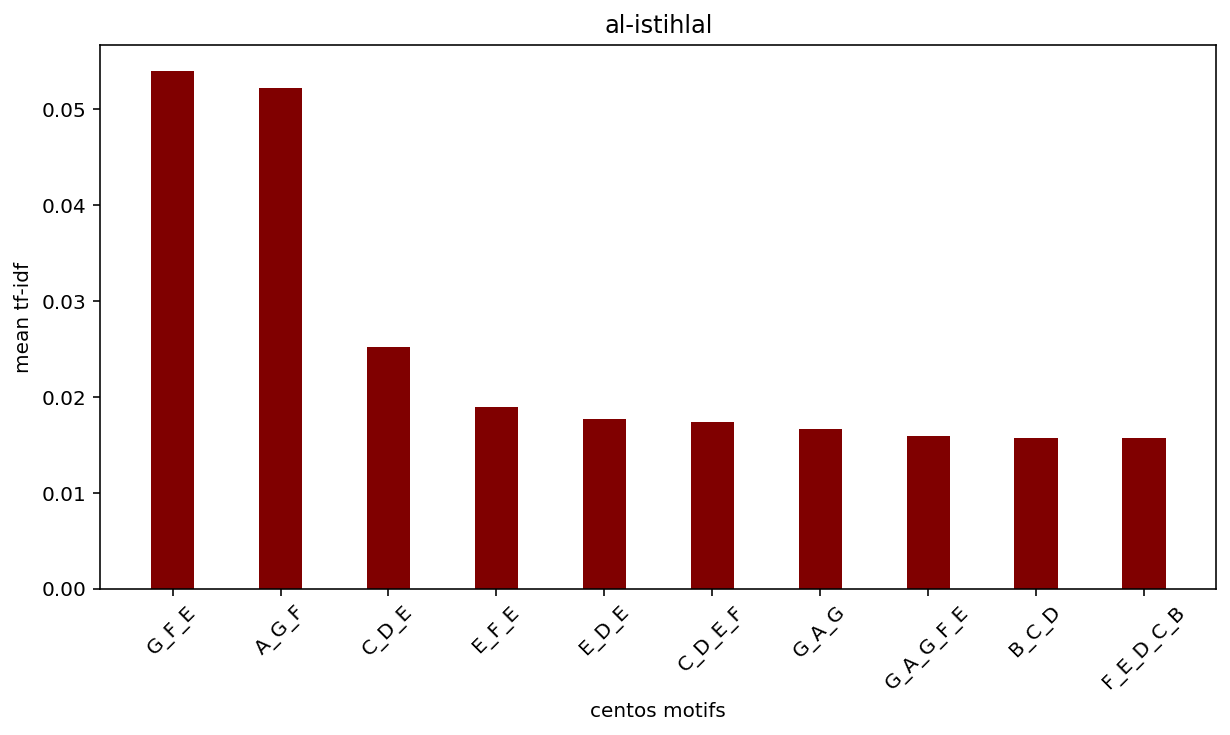

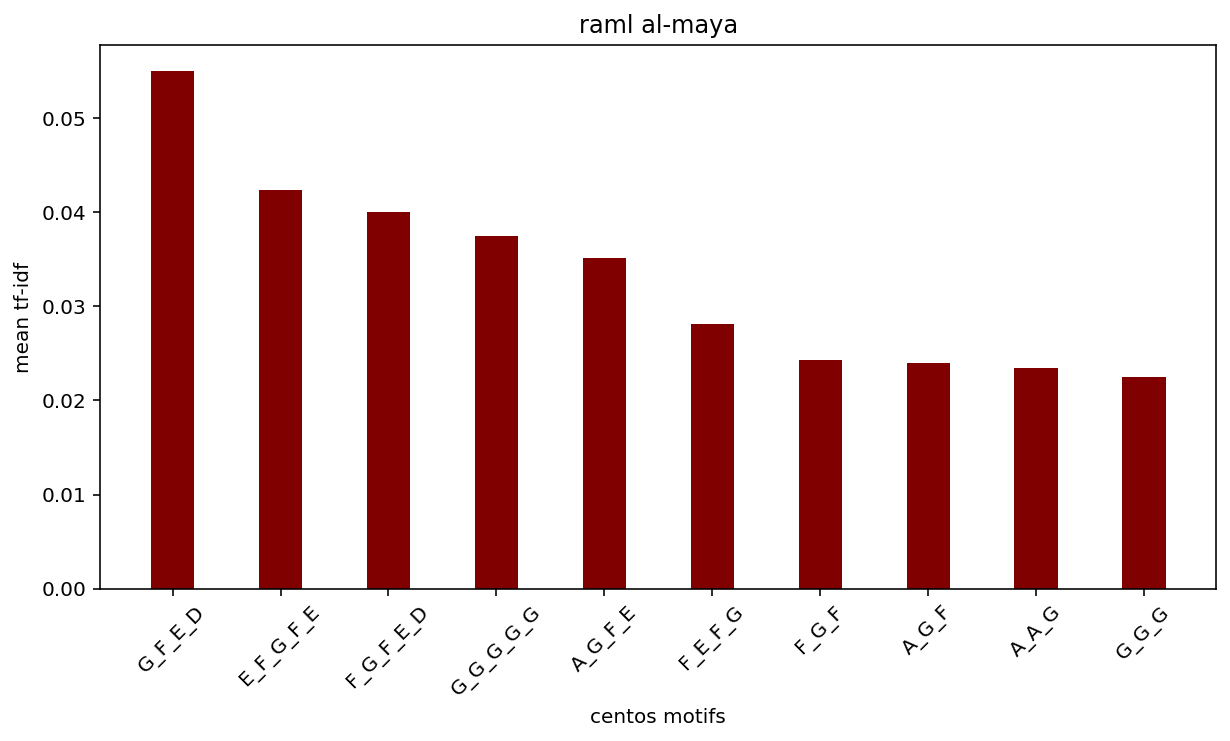

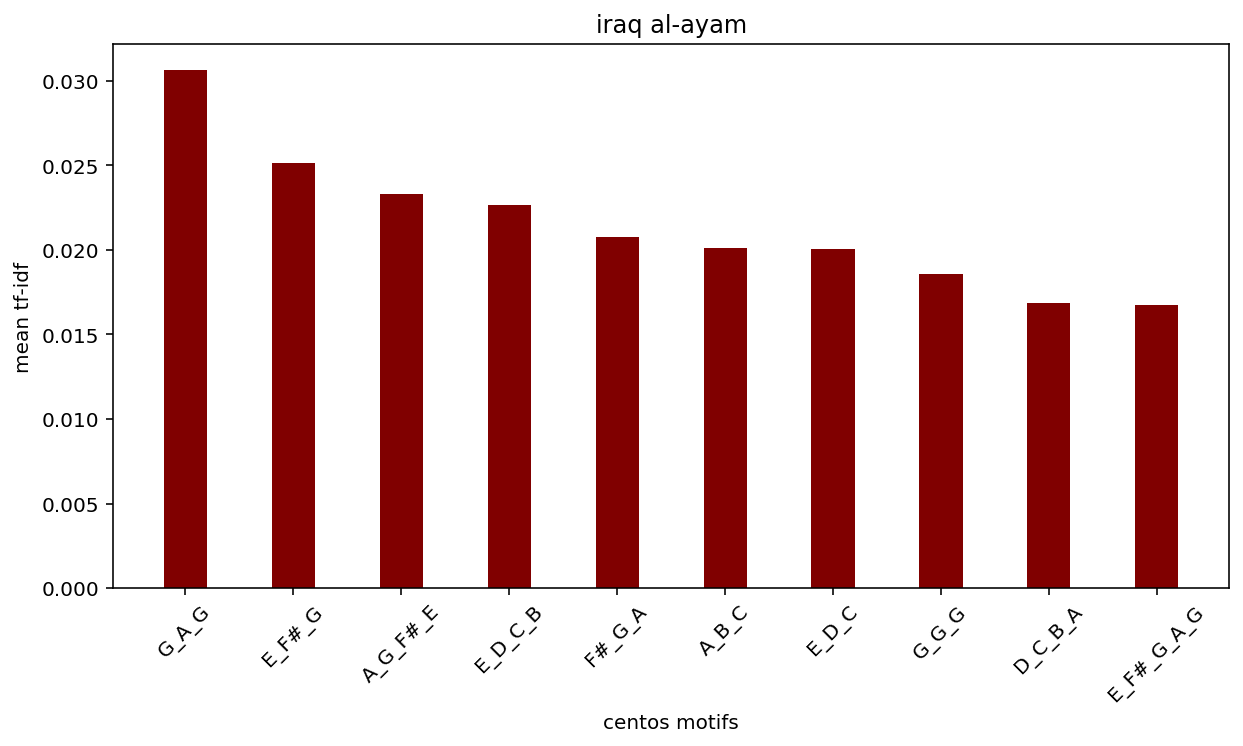

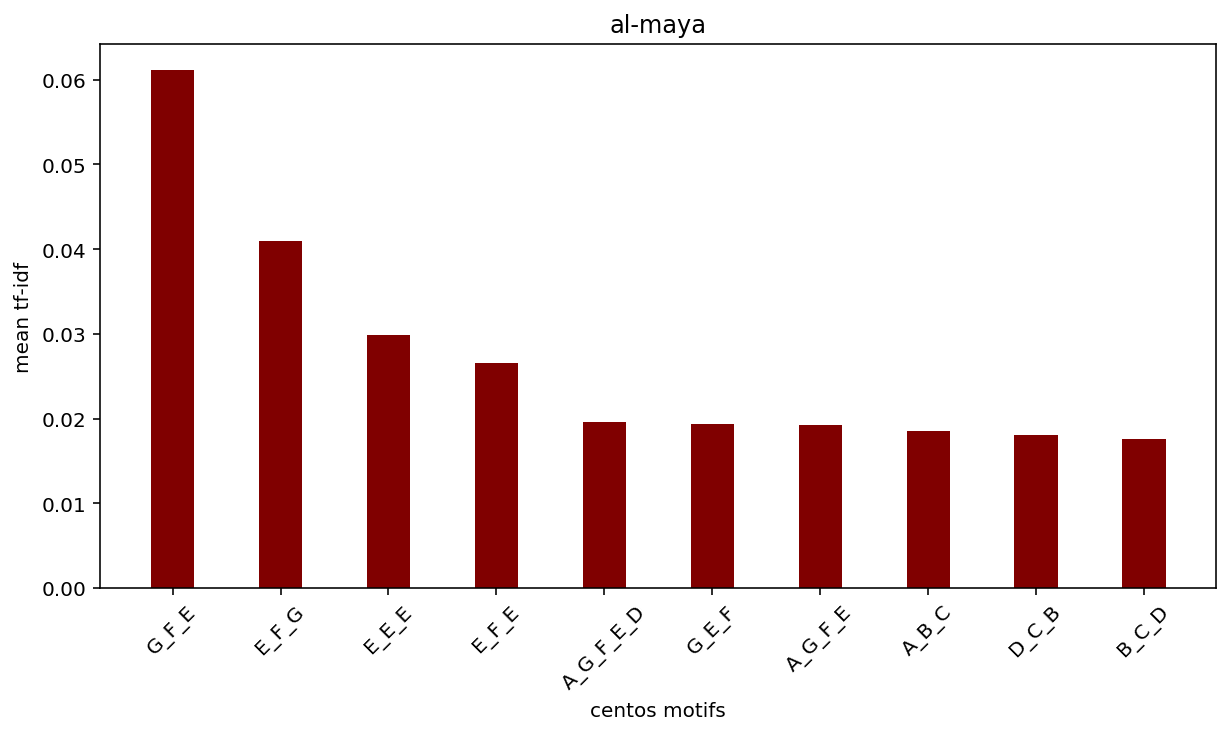

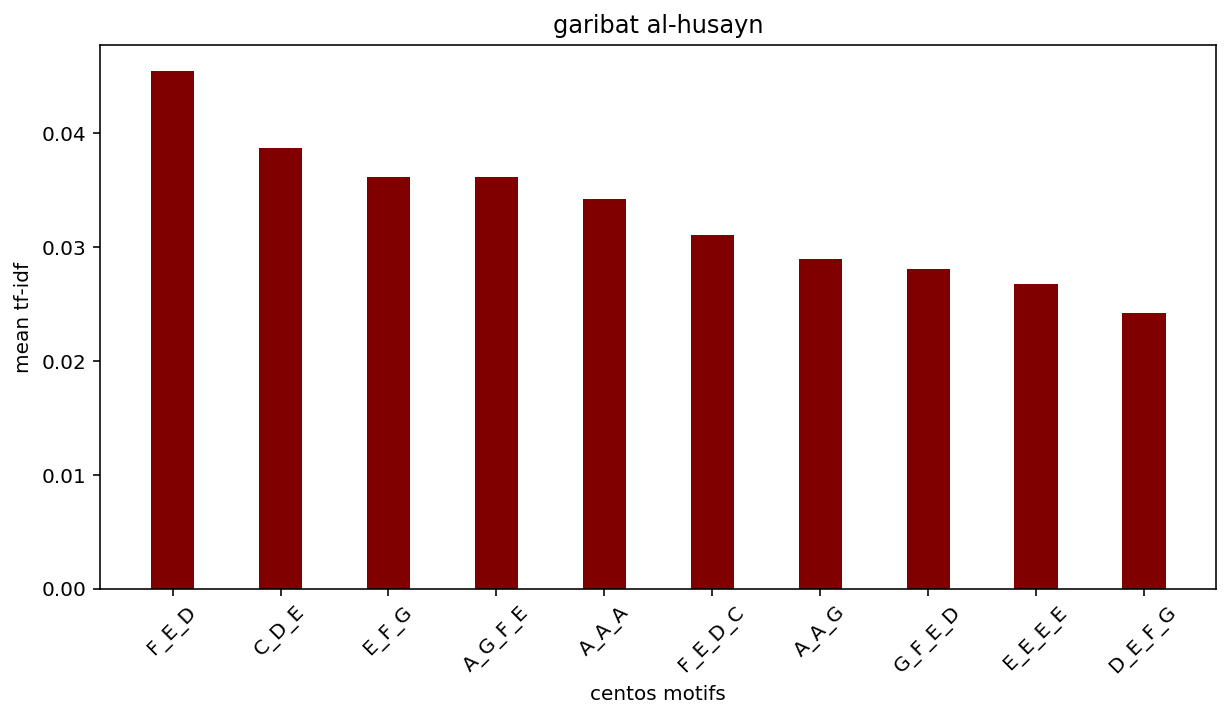

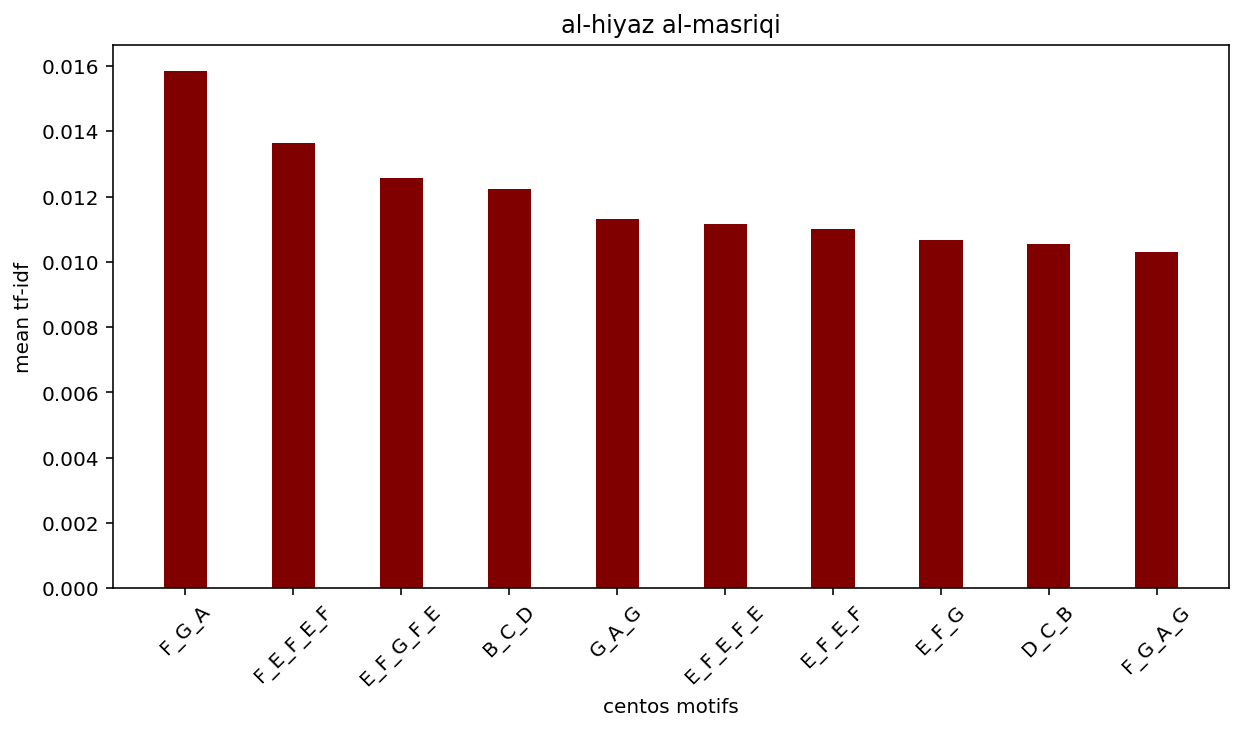

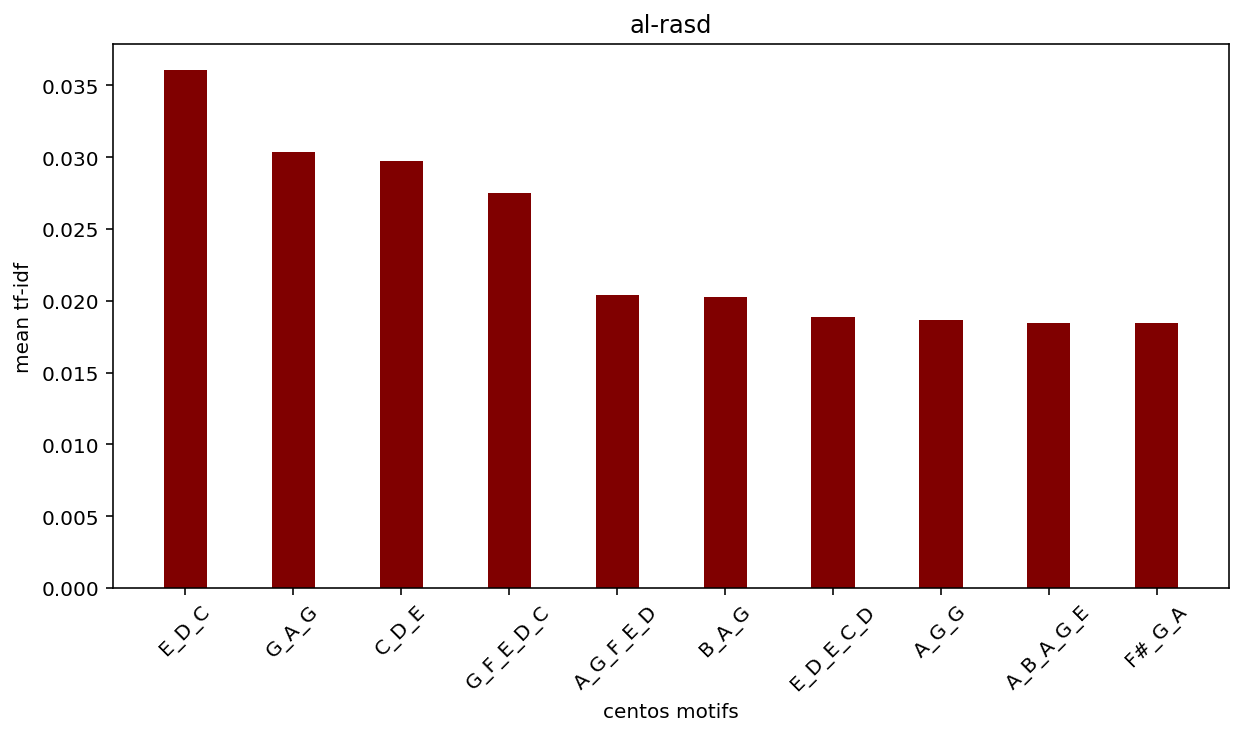

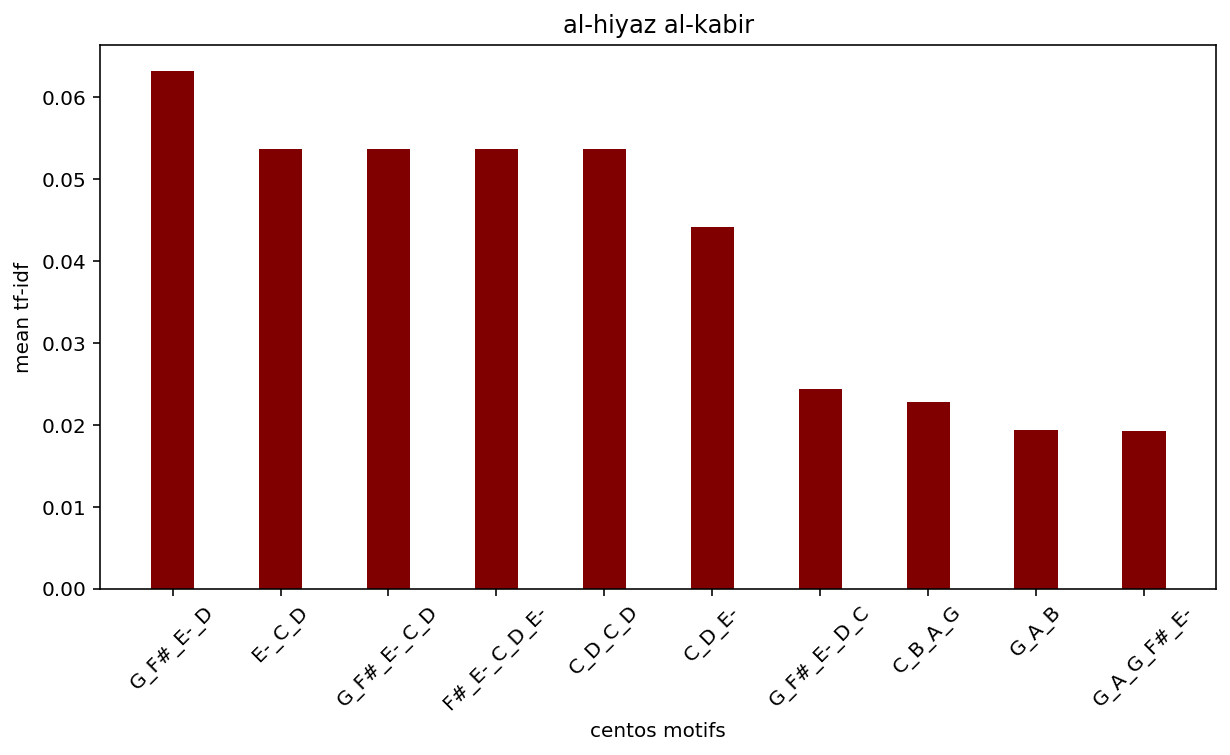

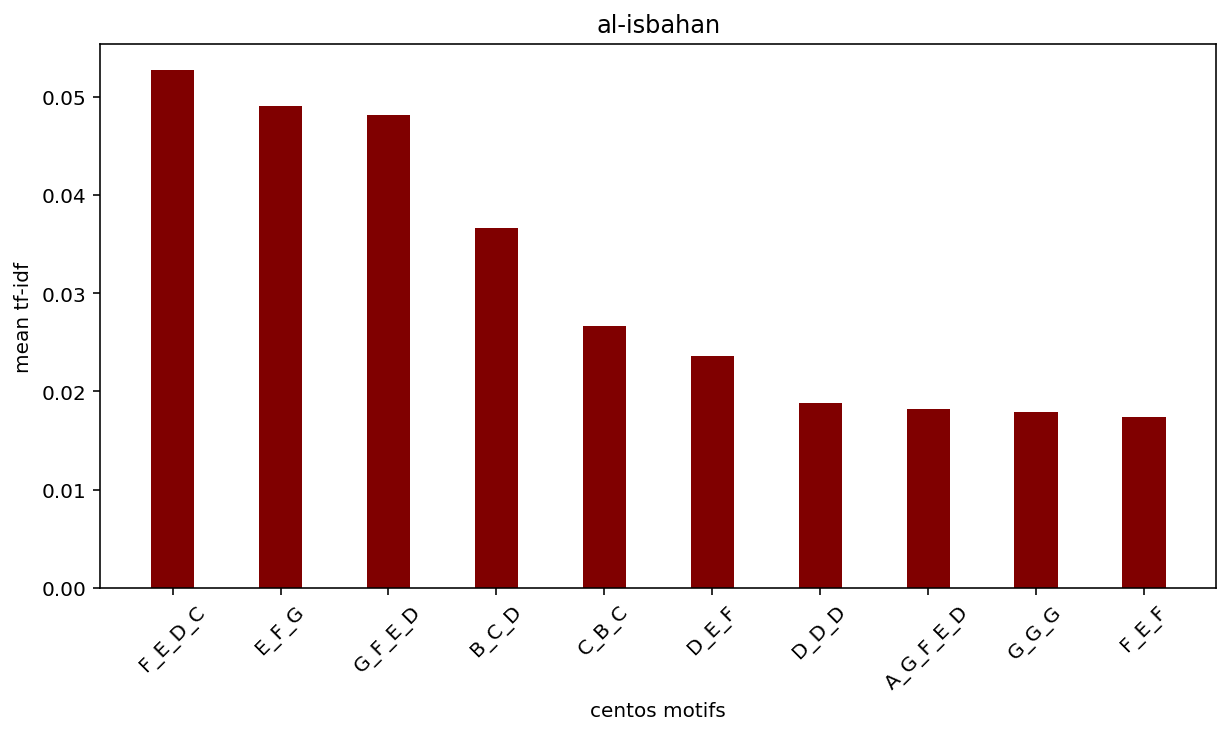

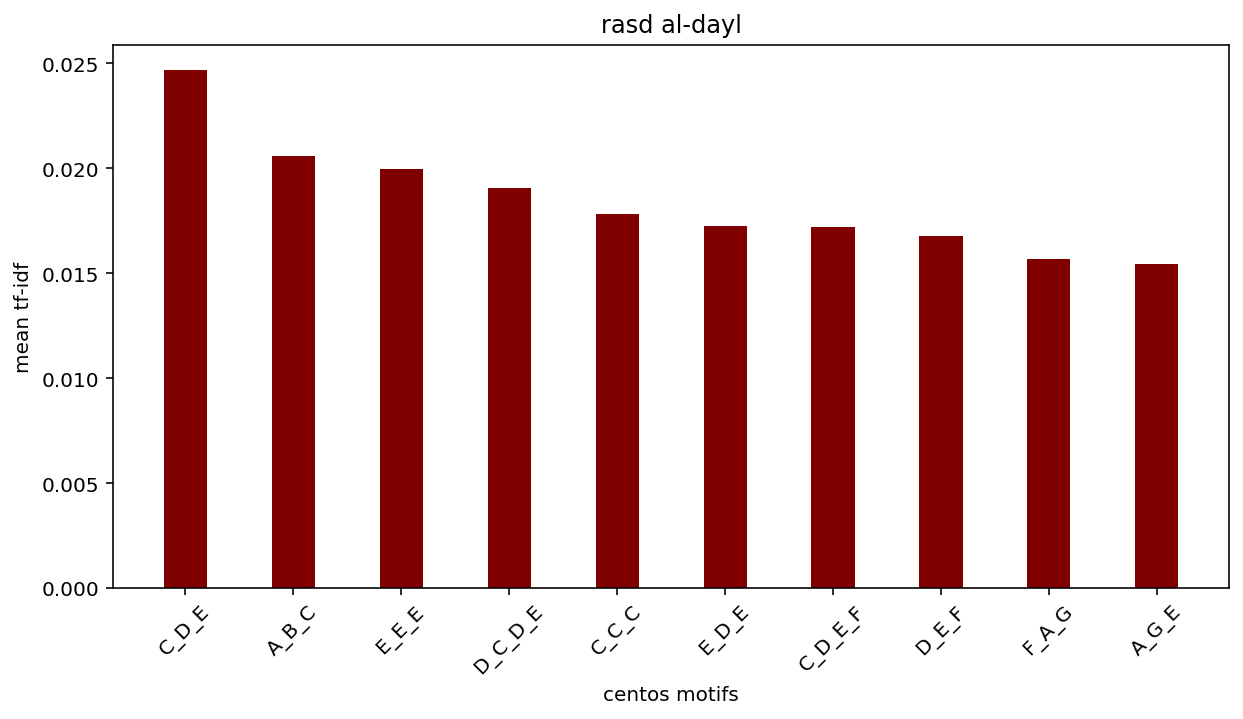

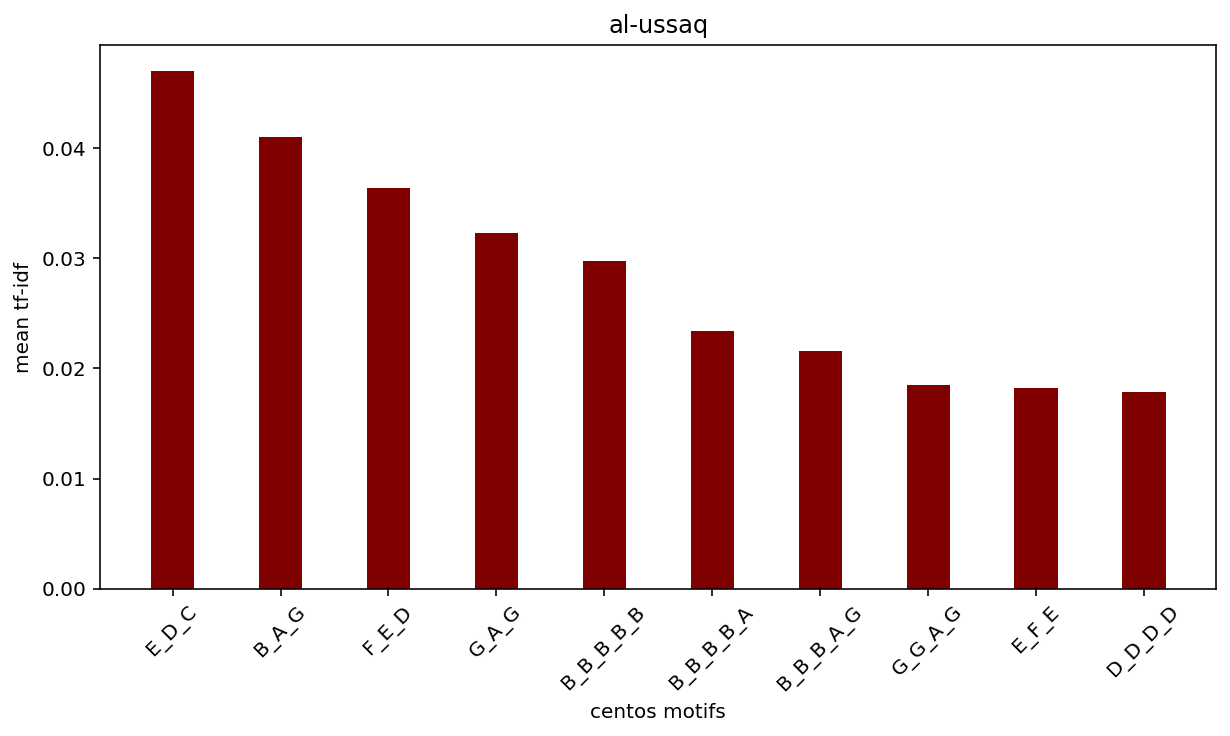

In [72]:
for tab in list(tab_motifs.keys()):
    df = pd.DataFrame(data=dataframes[tab])
    # mean of each motif
    word_means = df.mean(axis = 0)
    df.loc['mean'] = word_means
    dfObj = df.sort_values(by='mean', axis=1, ascending=False)
    fig = plt.figure(figsize = (10, 5))
    plt.bar(dfObj.columns[0:10], dfObj.loc['mean'][0:10], color ='maroon', width = 0.4)
    plt.title(tab)
    plt.xlabel('centos motifs')
    plt.xticks(rotation=45)
    plt.ylabel('mean tf-idf')